<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# TF-TRT Inference from Keras Model with Tensorflow 2.0

In this notebook, we demonstrate the process to create a TF-TRT optimized model from a Keras saved model.

## Requirement
We first install several helper Python libraries and import the required libraries.

In [ ]:
!pip install pillow --user

In [ ]:
!pip install matplotlib --user

In [27]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
print("Tensorflow version: ", tf.version.VERSION)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

#check TensorRT version
print("TensorRT version: ")
!dpkg -l | grep nvinfer

Tensorflow version:  2.1.0-dev20191006
TensorRT version: 
ii  libnvinfer-dev                   5.1.5-1+cuda10.0                  amd64        TensorRT development libraries and headers
ii  libnvinfer5                      5.1.5-1+cuda10.0                  amd64        TensorRT runtime libraries


In [28]:
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
tensor_core_gpu = check_tensor_core_gpu_present()

Tensor Core GPU Present: True


## Data
We download several images from the Internet.

In [13]:
!mkdir ./data
!wget  -O ./data/img1.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"

mkdir: cannot create directory ‘./data’: File exists
--2019-10-07 00:59:24--  https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630
Resolving d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)... 13.35.127.158, 13.35.127.161, 13.35.127.70, ...
Connecting to d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)|13.35.127.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24112 (24K) [image/jpeg]
Saving to: ‘./data/img1.JPG’

./data/img1.JPG     100%[===================>]  23.55K  --.-KB/s    in 0s      

2019-10-07 00:59:25 (262 MB/s) - ‘./data/img1.JPG’ saved [24112/24112]



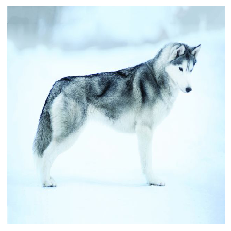

In [43]:
img_path = './data/img1.JPG'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img);
plt.axis('off');

## Model

We download a ResNet-50 saved Keras model.

In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

img_path = './data/img1.JPG'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])
# Predicted: [('n02110185', 'Siberian_husky', 0.55662125), ('n02109961', 'Eskimo_dog', 0.4173722), ('n02110063', 'malamute', 0.020951565)]

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02110185', 'Siberian_husky', 0.55662125), ('n02109961', 'Eskimo_dog', 0.4173722), ('n02110063', 'malamute', 0.020951565)]


TF-TRT work with TensorFlow saved model, therefore, we re-export the Keras model as a TF saved model.

In [5]:
# Save the entire model as a SavedModel.
model.save('resnet50_saved_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: resnet50_saved_model/assets


In [44]:
!saved_model_cli show --all --dir resnet50_saved_model


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['probs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1000)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Defined Functions:
  Function Name: '__call__'


In [6]:
!ls resnet50_saved_model

assets	saved_model.pb	variables


In [35]:
model = tf.keras.models.load_model('resnet50_saved_model')


In [36]:
model

In [37]:
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02110185', 'Siberian_husky', 0.55662125), ('n02109961', 'Eskimo_dog', 0.4173722), ('n02110063', 'malamute', 0.020951565)]


### TF-TRT FP32 model

We first convert the TF naitive FP32 model to a TF-TRT FP32 model.

In [7]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
converter = trt.TrtGraphConverterV2(
   input_saved_model_dir='resnet50_saved_model')
converter.convert()
#optionally build TRT engines before deployment
#convert.build(input_fn=my_input_fn)
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP32')


INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP32/assets


In [34]:
!ls resnet50_saved_model_TFTRT_FP32

assets	saved_model.pb	variables


In [45]:
model_TFTRT_FP32 = tf.keras.models.load_model('resnet50_saved_model_TFTRT_FP32')


In [38]:
!saved_model_cli show --all --dir resnet50_saved_model_TFTRT_FP32

['WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.',
 'Instructions for updating:',
 'If using Keras pass *_constraint arguments to layers.',
 '',
 "MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:",
 '',
 "signature_def['__saved_model_init_op']:",
 '  The given SavedModel SignatureDef contains the following input(s):',
 '  The given SavedModel SignatureDef contains the following output(s):',
 "    outputs['__saved_model_init_op'] tensor_info:",
 '        dtype: DT_INVALID',
 '        shape: unknown_rank',
 '        name: NoOp',
 '  Method name is: ',
 '',
 "signature_def['serving_default']:",
 '  The given SavedModel SignatureDef contains the following input(s):',
 "    inputs['input_2'] tensor_info:",
 '        dtype: DT_FLOAT',
 ' 

In [46]:
model_TFTRT_FP32

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f347fdcf278>

In [31]:
preds = model_TFTRT_FP32.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

AttributeError: '_UserObject' object has no attribute 'predict'

### TF-TRT FP16 model
We first convert the TF

In [14]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP16, 
                                                                       max_batch_size=1, 
                                                                       max_workspace_size_bytes=8000000000)

converter = trt.TrtGraphConverterV2(
   input_saved_model_dir='resnet50_saved_model', conversion_params=conversion_params)
converter.convert()
#optionally build TRT engines before deployment
#convert.build(input_fn=my_input_fn)
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP16')


INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP16/assets


### TF-TRT INT8 model

In [22]:
def calibration_input_fn(): 
    features = np.random.rand(64,224,224,3)
    labels = np.random.randint(0, 1000, (64,1))
    return features, labels
    

In [ ]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.INT8, 
                                                                       max_batch_size=1, 
                                                                       max_workspace_size_bytes=8000000000)

converter = trt.TrtGraphConverterV2(
   input_saved_model_dir='resnet50_saved_model', conversion_params=conversion_params)
converter.convert(calibration_input_fn =calibration_input_fn )
#optionally build TRT engines before deployment
#convert.build(input_fn=my_input_fn)
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_INT8')


## Conclusion
In this notebook, we have demonstrated the process of creating TF-TRT inference model from an original Keras FP32 model. 
